# FAKE NEWS CLASSIFICATION

## LIBRARIES

In [1]:
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import string
import time
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
from textblob import TextBlob
from xgboost import XGBClassifier
%matplotlib inline


## DATA PREPERATION

In [2]:
# Read CSV Dataset Files

fake_data = pd.read_csv('./dataset/Fake.csv')
true_data = pd.read_csv('./dataset/True.csv')

# Create 'target' for fake and real news

fake_data['target'] = 'fake'
true_data['target'] = 'true'

# Concatenate both DataFrames into a single dataset containing both real and fake news 

news_dataset = pd.concat([fake_data, true_data]).reset_index(drop = True)

# Shuffle the data to prevent overfitting and dataset memorization

news_dataset = shuffle(news_dataset)
news_dataset = news_dataset.reset_index(drop=True)

#  Adjust columns in news_dataset

news_dataset['news']=news_dataset['title']+news_dataset['text']
news_dataset=news_dataset.drop(['title', 'text'], axis=1)
news_dataset['date'].value_counts()

# Make Dataset Smaller for Faster Run Time

news_dataset_chunk  = news_dataset[:500]

# Place independent features in X variable 

X = news_dataset_chunk.drop('target',axis =1)

# Place 'target' values (True or False) in y variable

y = news_dataset_chunk['target']

# Create a copy of the adjusted dataset

news_dataset_copy = news_dataset_chunk.copy()

# EXPLORATORY DATA ANALYSIS 

## Exploring word count of real and fake news

In [3]:
# Compute word-count for each news article

news_dataset['word_count'] = news_dataset['news'].apply(lambda x: len(str(x).split()))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


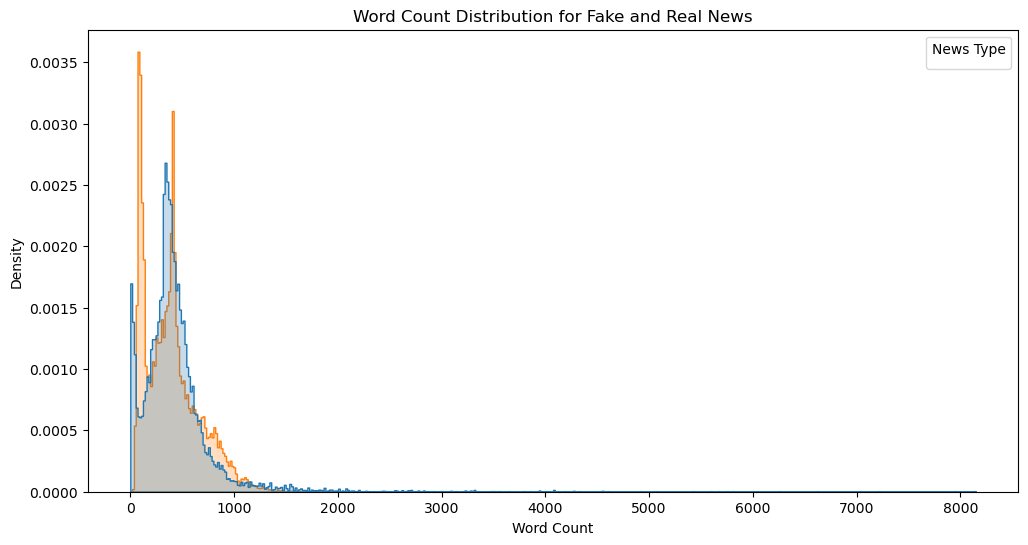

In [4]:
# Plotting word count between real and fake News

plt.figure(figsize=(12, 6))
sns.histplot(news_dataset, x='word_count', hue='target', element='step', stat='density', common_norm=False)
plt.title('Word Count Distribution for Fake and Real News')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='News Type')
plt.show()

## Exploring title length of real and fake news

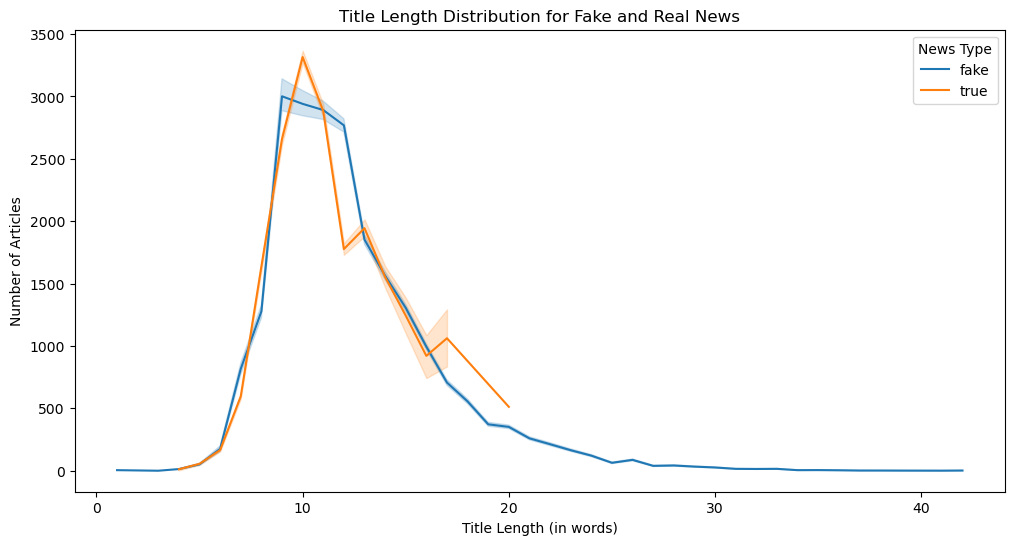

In [5]:
fake_data['title_length'] = fake_data['title'].apply(lambda x: len(str(x).split()))
true_data['title_length'] = true_data['title'].apply(lambda x: len(str(x).split()))

# Combine the dataframes for visualization

combinded_dataset = pd.concat([fake_data, true_data])

# Sort by title length for a smoother line graph

combinded_dataset = combinded_dataset.sort_values(by="title_length").reset_index(drop=True)

# Plot Results

plt.figure(figsize=(12, 6))
sns.lineplot(data=combinded_dataset, x='title_length', y=combinded_dataset.groupby('title_length').cumcount(), hue='target')
plt.title('Title Length Distribution for Fake and Real News')
plt.xlabel('Title Length (in words)')
plt.ylabel('Number of Articles')
plt.legend(title='News Type')
plt.show()

## Exploring punctuation usage of real and fake news

In [6]:
# Extract Count Specfic Punctuation

def count_specific_punct(text, punct):
    return text.count(punct)

punctuation_list = ['.', ',', '?', '!', ':', ';']

for punct in punctuation_list:
    news_dataset[punct] = news_dataset['news'].apply(lambda x: count_specific_punct(x, punct))

# Calculate Mean Counts for Each Punctuation

mean_punctuation_counts = news_dataset.groupby('target')[punctuation_list].mean().transpose()


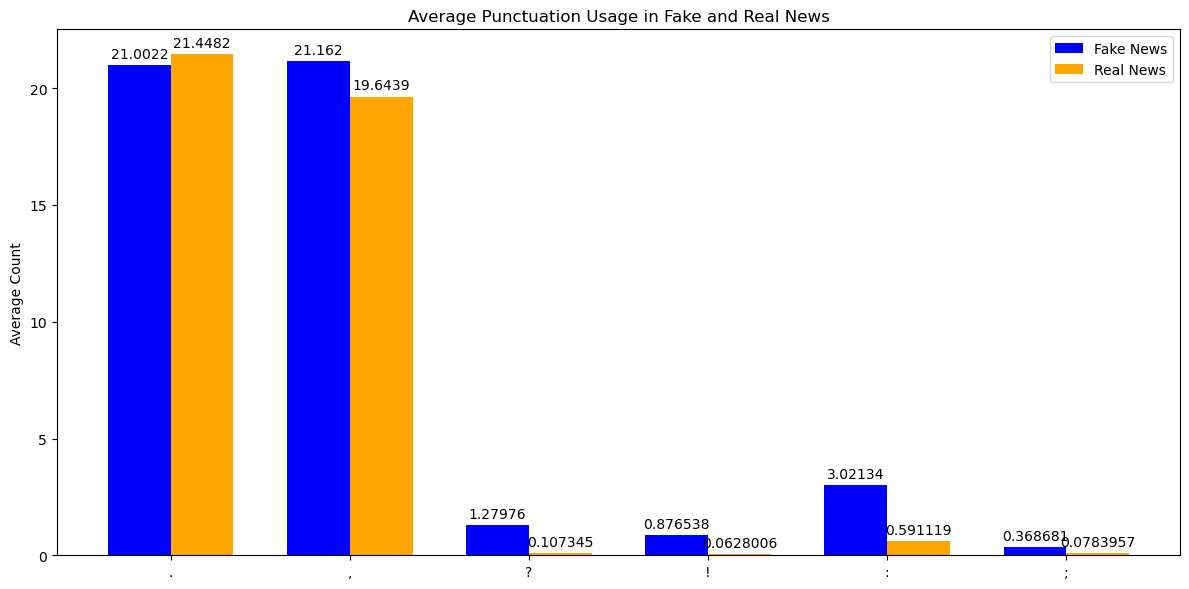

In [7]:
# Plot Results

labels = mean_punctuation_counts.index
fake_counts = mean_punctuation_counts['fake']
real_counts = mean_punctuation_counts['true']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, fake_counts, width, label='Fake News', color='blue')
rects2 = ax.bar(x + width/2, real_counts, width, label='Real News', color='orange')

ax.set_ylabel('Average Count')
ax.set_title('Average Punctuation Usage in Fake and Real News')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()




## Explore Lexical Diversity

In [8]:
# Compute Lexical Diversity 

def lexical_diversity(text):
    texts = text.split()
    if len(texts) == 0:  
        return 0
    return len(set(texts)) / len(texts)

news_dataset['lexical_diversity'] = news_dataset['news'].apply(lexical_diversity)

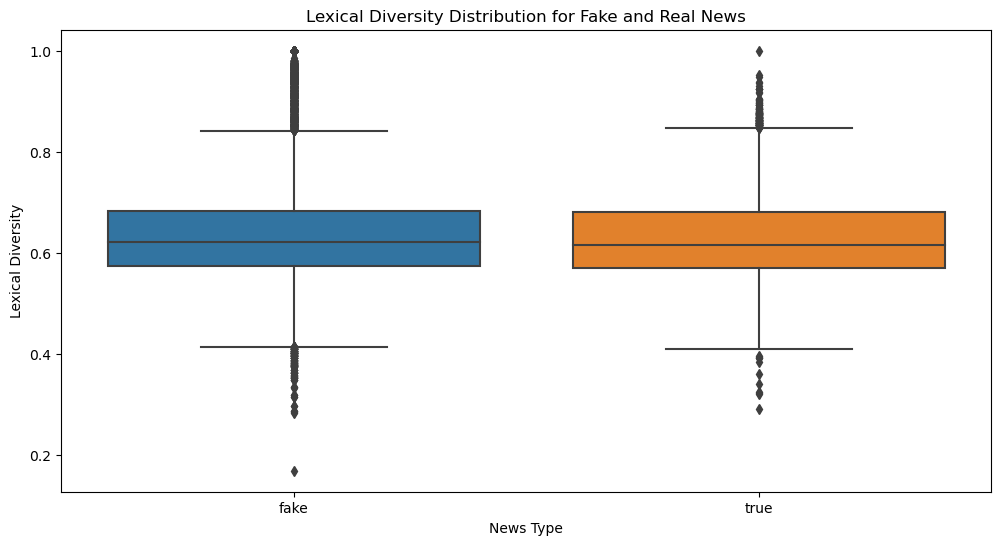

In [9]:
# Plot Results

plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='lexical_diversity', data=news_dataset)
plt.title('Lexical Diversity Distribution for Fake and Real News')
plt.xlabel('News Type')
plt.ylabel('Lexical Diversity')
plt.show()

## Exploring Sentiment Analysis

In [10]:
def get_sentiment(text):
    sentiment_analysis = TextBlob(text)
    return sentiment_analysis.sentiment.polarity

In [11]:
news_dataset['sentiment'] = news_dataset['news'].apply(get_sentiment)


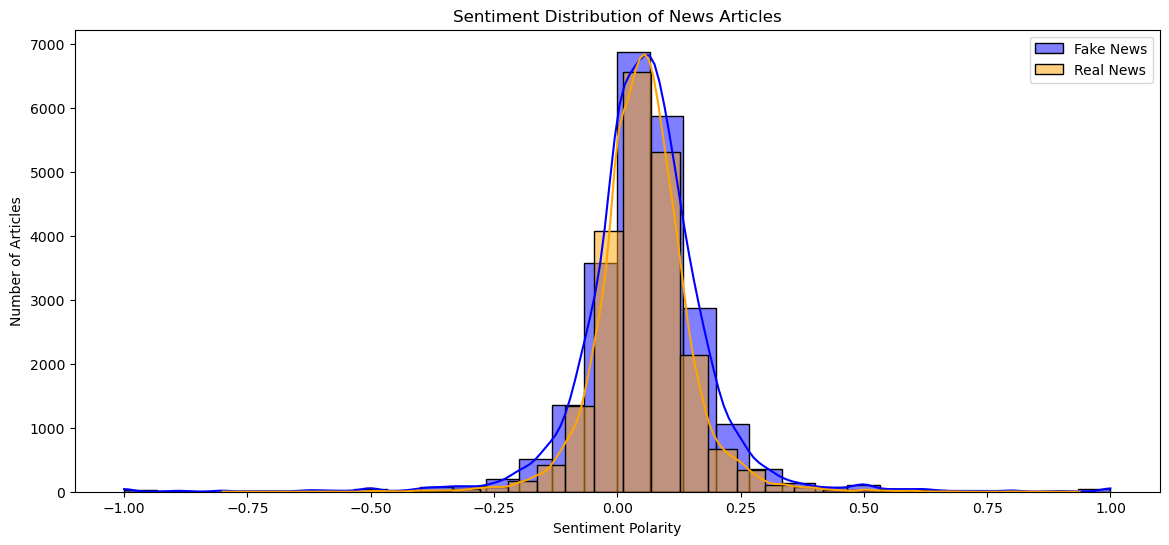

In [12]:
plt.figure(figsize=(14, 6))

# Plot sentiment for fake news
sns.histplot(news_dataset[news_dataset['target'] == 'fake']['sentiment'], color='blue', label='Fake News', bins=30, kde=True)

# Plot sentiment for real news
sns.histplot(news_dataset[news_dataset['target'] == 'true']['sentiment'], color='Orange', label='Real News', bins=30, kde=True)

plt.title('Sentiment Distribution of News Articles')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

## TOKENIZATION AND TEXT PREPROCESSING

In [14]:
ps = PorterStemmer()
adj = re
array_= []

for i in range(0, len(news_dataset_copy)):
      words_adjustment = adj.sub('[^a-zA-Z]', ' ', news_dataset_copy['news'][i])
      words_adjustment = adj.sub('https?://\S+|www\.\S+', '', news_dataset_copy['news'][i])
      words_adjustment = adj.sub('<.*?>+', '', news_dataset_copy['news'][i])
      words_adjustment = adj.sub('[%s]' % adj.escape(string.punctuation), '', news_dataset_copy['news'][i])
      words_adjustment = adj.sub('\n', '', news_dataset_copy['news'][i])
      words_adjustment = adj.sub('\w*\d\w*', '', news_dataset_copy['news'][i])
      words_adjustment = words_adjustment.lower()
      words_adjustment = words_adjustment.split()
      words_adjustment = [ps.stem(word) for word in words_adjustment if not word in stopwords.words('english')]
      words_adjustment = ' '.join(words_adjustment)
      array_.append(words_adjustment)



## BAG WORDS AND COUNT VECTORS

In [15]:
count_vectors = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = count_vectors.fit_transform(array_).toarray()
X.shape 
y =news_dataset_copy['target']

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)

In [17]:
count_vectors_features = pd.DataFrame(X_train,columns = count_vectors.get_feature_names_out())

## Model Builder and Graph Results

In [22]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    # Record start time
    start = time.time()
    
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    
    # Record end time
    end = time.time()

    # Calculate runtime
    runtime = end - start

    # Evaluation of Results
    accuracy_ = accuracy_score(y_test, prediction)
    f1_ = f1_score(y_test, prediction, zero_division=0, pos_label='true')
    precision_ = precision_score(y_test, prediction, zero_division=0, pos_label='true')
    recall_ = recall_score(y_test, prediction, zero_division=0, pos_label='true')
    
    percent_conversion = accuracy_ * 100
    print("Accuracy: %0.2f%%" % percent_conversion)
    print("F1 Score:", f1_)
    print("Precision:", precision_)
    print("Recall:", recall_)
    print("Runtime:", runtime, "seconds")  # Print runtime
    
    cf_matrix = confusion_matrix(y_test, prediction)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()



# MultinomialNB

Accuracy: 93.00%
F1 Score: 0.9195402298850575
Precision: 0.9090909090909091
Recall: 0.9302325581395349
Runtime: 0.023289203643798828 seconds


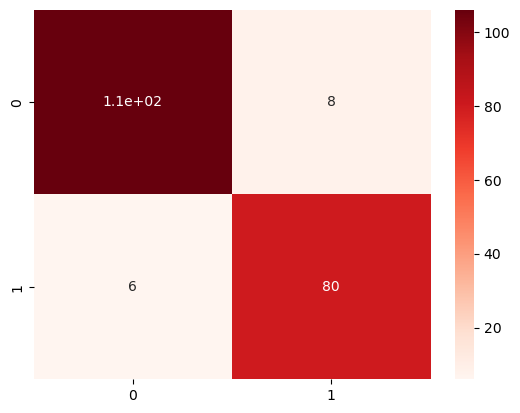

In [23]:
MultinomialNB_classifier = MultinomialNB()
evaluate_classifier(MultinomialNB_classifier, X_train, y_train, X_test, y_test, heatmap_color='Reds')

# kNN Classification

Accuracy: 67.50%
F1 Score: 0.43478260869565216
Precision: 0.8620689655172413
Recall: 0.29069767441860467
Runtime: 0.03268241882324219 seconds


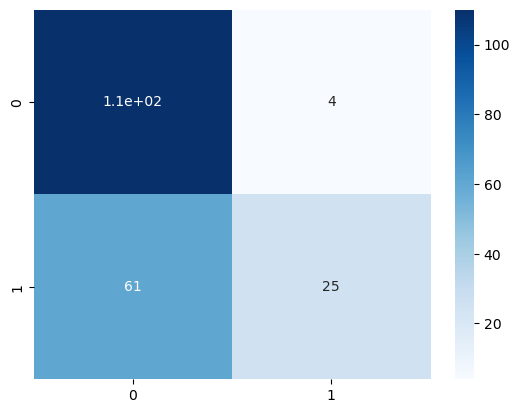

In [24]:
knn_classifier = KNeighborsClassifier()
evaluate_classifier(knn_classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues')

# Logistic Regression 

Accuracy: 94.00%
F1 Score: 0.9310344827586208
Precision: 0.9204545454545454
Recall: 0.9418604651162791
Runtime: 0.12010502815246582 seconds


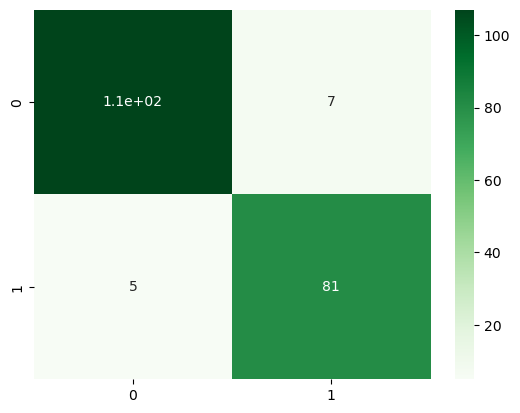

In [25]:
logreg_classifier = LogisticRegression()
evaluate_classifier(logreg_classifier, X_train, y_train, X_test, y_test, heatmap_color = "Greens")

# Random Forest Classifier

Accuracy: 99.00%
F1 Score: 0.9883720930232558
Precision: 0.9883720930232558
Recall: 0.9883720930232558
Runtime: 1.6649434566497803 seconds


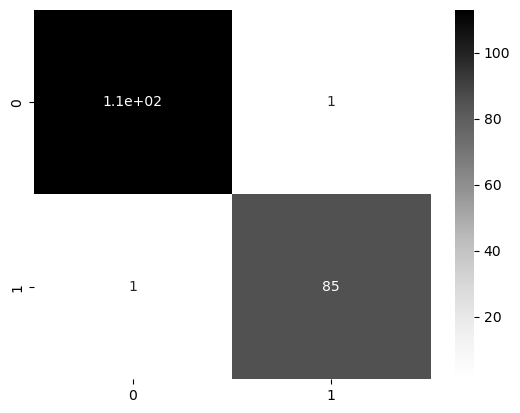

In [26]:
rfc = RandomForestClassifier(n_estimators = 600, bootstrap = True, random_state=8)
evaluate_classifier(rfc, X_train, y_train, X_test, y_test, heatmap_color = "Greys")

# Passive Agressive Classifier

Accuracy: 93.50%
F1 Score: 0.9257142857142857
Precision: 0.9101123595505618
Recall: 0.9418604651162791
Runtime: 0.0674140453338623 seconds


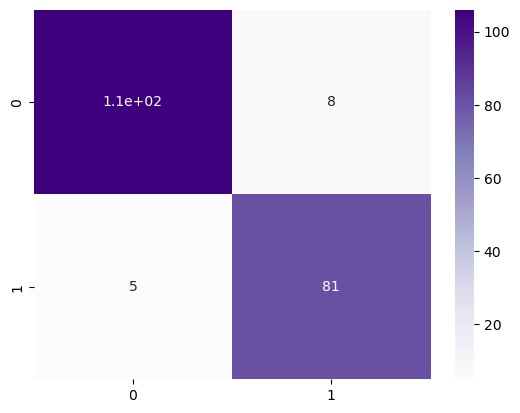

In [27]:
pac = PassiveAggressiveClassifier()
evaluate_classifier(pac, X_train, y_train, X_test, y_test, heatmap_color = "Purples")

## Models from Scratch

In [28]:
def evaluate_classifier_scratch(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    
    # Record start time
    start = time.time()
    
    classifier.fit(X_train, y_train)
    prediction = classifier.prediction(X_test)
    
     # Record end time
    end = time.time()

    # Calculate runtime
    runtime = end - start
    
    # Evaluation of Results
    accuracy_ = accuracy_score(y_test, prediction)
    f1_ = f1_score(y_test, prediction, zero_division=0, pos_label=true_label)
    precision_ = precision_score(y_test, prediction, zero_division=0, pos_label=true_label)
    recall_ = recall_score(y_test, prediction, zero_division=0, pos_label=true_label)
    print("Runtime:", runtime, "seconds")  # Print runtime

    print(f"Acc: {accuracy_ * 100:.2f}%")
    print(f"F1 Score: {f1_:.4f}")
    print(f"Precision: {precision_:.4f}")
    print(f"Recall: {recall_:.4f}")

    cf_matrix = confusion_matrix(y_test, prediction)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()
    

# MultinomialNB (from scratch)


In [31]:
class MultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def fit(self, X, y):
        m_value, n = X.shape
        self._class = np.unique(y)
        class_number = len(self._class)
    
        # Create a mapping from class label to index
        self.index_class = {label: index for index, label in enumerate(self._class)}
    
        self.probability_class = np.zeros(class_number)
        self.probability_feature = np.zeros((class_number, n))

        # Class probabilities: P(y = c)
        for c in self._class:
            idx_class = self.index_class[c]  
            self.probability_class[idx_class] = np.sum(y == c) / m_value 

        # Conditional probabilities: P(x_i|y = c)
        for c in self._class:
            idx_class = self.index_class[c]  
            Xc = X[y == c]
            self.probability_feature[idx_class] = (Xc.sum(axis=0) + self.alpha) / (np.sum(Xc.sum(axis=0) + self.alpha))

        return self

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        posts = []

        # Calculate posterior probability for each class
        for idx, c in enumerate(self._class):
            oneback = np.log(self.probability_class[idx])
            conditional_probability = sum(np.log(self.probability_feature[idx][x == 1]))  # Use probability_feature here instead of cond_probs_
            post = oneback + conditional_probability
            posts.append(post)

        # Return class with highest posterior probability
        return self._class[np.argmax(posts)]


Accuracy: 96.00%
F1 Score: 0.9534883720930233
Precision: 0.9534883720930233
Recall: 0.9534883720930233
Runtime: 0.06540322303771973 seconds


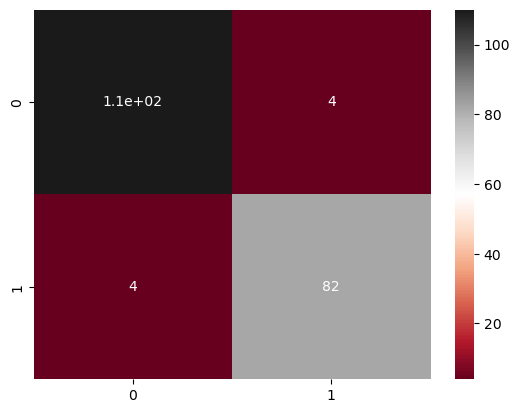

In [32]:
mnb_classifier = MultinomialNB(alpha=1.0)
evaluate_classifier(mnb_classifier, X_train, y_train, X_test, y_test, heatmap_color='RdGy')

# kNN Classification (from Scratch)

In [33]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def prediction(self, X):
        prediction_y = [self._predict(x) for x in X]
        return np.array(prediction_y)

    def _predict(self, x):
        # Compute dist between x and all examples in the training set
        dist = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        
        # Sort by distance and return indices of the first k neighbors
        idx_k = np.argsort(dist)[:self.k]
        
        # Extract the labels of the k nearest neighbor training samples
        knl = [self.y_train[i] for i in idx_k]
        
        # Return the most common class label
        highest_relation = np.bincount(knl).argmax()
        return highest_relation
 

Runtime: 0.7275295257568359 seconds
Acc: 68.00%
F1 Score: 0.4576
Precision: 0.8438
Recall: 0.3140


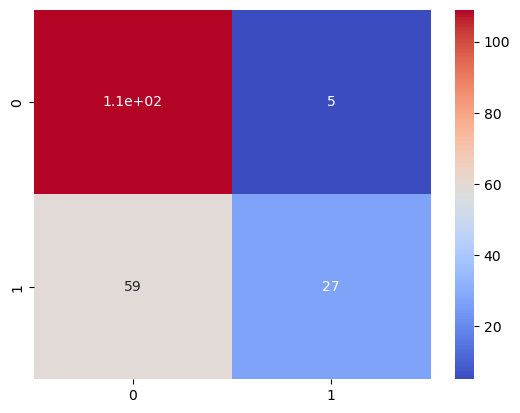

In [34]:
label_encd = LabelEncoder()
y_train_encoded = label_encd.fit_transform(y_train)
y_test_encoded = label_encd.transform(y_test)
true_label = label_encd.transform(['true'])[0]

knn_classifier = KNN(k=3)
evaluate_classifier_scratch(knn_classifier, X_train, y_train_encoded, X_test, y_test_encoded, heatmap_color='coolwarm')


# Logistic Regression (from Scratch)

In [35]:
class LogisticRegressionModel:
    def __init__(self, rate_learning=0.01, n_iterations=1000):
        self.rate_learning = rate_learning
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    def probability_prediction(self, X):
        linear = np.dot(X, self.weights) + self.bias
        return 1 / (1 + np.exp(-linear))
    
    def prediction(self, X, thresh=0.5):
        return (self.probability_prediction(X) >= thresh).astype(int)
    
    def fit(self, X, y):
        m_value = X.shape[0]
        y = y.values.reshape(-1, 1)  
        self.weights = np.zeros((X.shape[1], 1))
        self.bias = 0
        
        for i in range(self.n_iterations):
            predictions = self.probability_prediction(X)
            
            dw = (1/m_value) * np.dot(X.T, (predictions - y))
            db = (1/m_value) * np.sum(predictions - y)
            
            self.weights -= self.rate_learning * dw
            self.bias -= self.rate_learning * db


In [36]:
news_dataset_copy['target'] = news_dataset_copy['target'].replace({'fake': 0, 'true': 1})
news_dataset_copy['target'].head()
y =news_dataset_copy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)


Runtime: 4.894998550415039 seconds
Acc: 94.50%
F1 Score: 0.9371
Precision: 0.9213
Recall: 0.9535


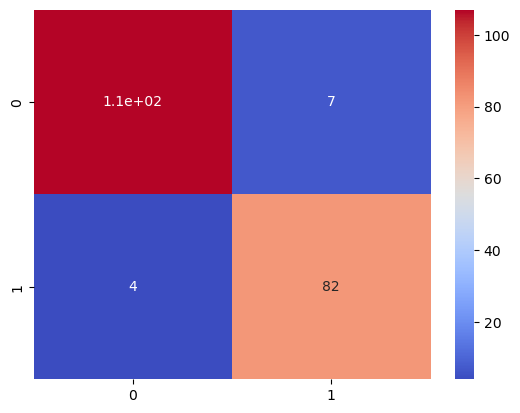

In [37]:
# Initialize the model
model = LogisticRegressionModel(rate_learning=0.01, n_iterations=1000)
evaluate_classifier_scratch(model, X_train, y_train, X_test, y_test, heatmap_color='coolwarm')



# Random Forest Classifier (from Scratch)

In [44]:
import numpy as np

class DecisionTree:
    def __init__(self, depth_maximum=None):
        self.depth_maximum = depth_maximum

    def _gn(self, y):
        m_value = len(y)
        return 1.0 - sum([(np.sum(y == c) / m_value) ** 2 for c in np.unique(y)])

    def _grow_tree(self, X, y, depth=0):
        sample_num, n_features = X.shape
        class_number = len(np.unique(y))
        if depth == self.depth_maximum or class_number == 1:
            return np.argmax(np.bincount(y))
        
        idx_features = np.random.choice(n_features, n_features, replace=False)
        gn_top = 1
        for feature_idx in idx_features:
            threshs = np.unique(X[:, feature_idx])
            for thresh in threshs:
                index_left = X[:, feature_idx] < thresh
                index_right = X[:, feature_idx] >= thresh
                if sum(index_left) == 0 or sum(index_right) == 0:
                    continue
                left_gn = self._gn(y[index_left])
                right_gn = self._gn(y[index_right])
                gn = (left_gn * sum(index_left) + right_gn * sum(index_right)) / sample_num
                if gn < gn_top:
                    gn_top = gn
                    top_thresh = thresh
                    top_idx = feature_idx
                    top_left_idxs = index_left
                    top_right_idxs = index_right
        
        tree_left = self._grow_tree(X[top_left_idxs], y[top_left_idxs], depth + 1)
        tree_right = self._grow_tree(X[top_right_idxs], y[top_right_idxs], depth + 1)
        return (top_idx, top_thresh, tree_left, tree_right)

    def fit(self, X, y):
        self.tree_ = self._grow_tree(X, y)
        
    def _sample_prediction(self, x, tree):
        if isinstance(tree, (int, np.integer)):
            return tree
        feature, thresh, tree_left, tree_right = tree
        if x[feature] < thresh:
            return self._sample_prediction(x, tree_left)
        else:
            return self._sample_prediction(x, tree_right)

    def prediction(self, X):
        return [self._sample_prediction(x, self.tree_) for x in X]


class RandomForestClassifier:
    def __init__(self, trees_num=100, depth_maximum=None):
        self.trees_num = trees_num
        self.depth_maximum = depth_maximum
        self.trees = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        for _ in range(self.trees_num):
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTree(depth_maximum=self.depth_maximum)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    def prediction(self, X):
        X = np.array(X)
        predictions = np.array([tree.prediction(X) for tree in self.trees])
        return np.array([np.bincount(preds).argmax() for preds in predictions.T])


Runtime: 19.069209098815918 seconds
Acc: 99.50%
F1 Score: 0.9942
Precision: 1.0000
Recall: 0.9884


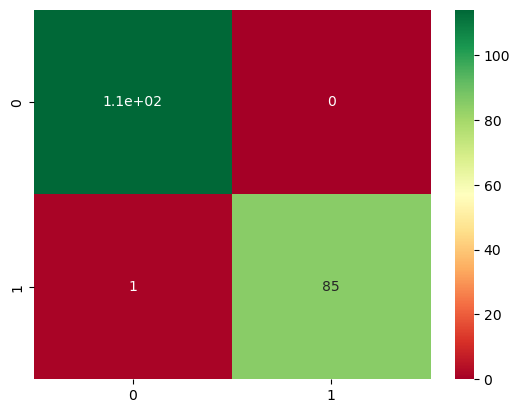

In [45]:
model = RandomForestClassifier(trees_num=10, depth_maximum=10)
evaluate_classifier_scratch(model, X_train, y_train, X_test, y_test, heatmap_color = "RdYlGn")


# Passive Agressive Classifier (from Scratch)

In [46]:
class PassiveAggressiveClassifier:
    def __init__(self, c_value=1.0, iteration_maximum=1000, total=1e-3):
        self.c_value = c_value
        self.iteration_maximum = iteration_maximum
        self.total = total
        self.w = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        sample_num, n_features = X.shape
        self.w = np.zeros(n_features)

        for _ in range(self.iteration_maximum):
            for i in range(sample_num):
                f = np.dot(X[i], self.w)
                if y[i] * f < 1:
                    loss = max(0, 1 - y[i] * f)
                    tau = loss / (np.linalg.norm(X[i]) ** 2 + 1 / (2 * self.c_value))
                    self.w += tau * y[i] * X[i]

        return self

    def prediction(self, X):
        X = np.array(X)
        return np.sign(np.dot(X, self.w))


Runtime: 5.213563442230225 seconds
Acc: 43.00%
F1 Score: 0.6014
Precision: 0.4300
Recall: 1.0000


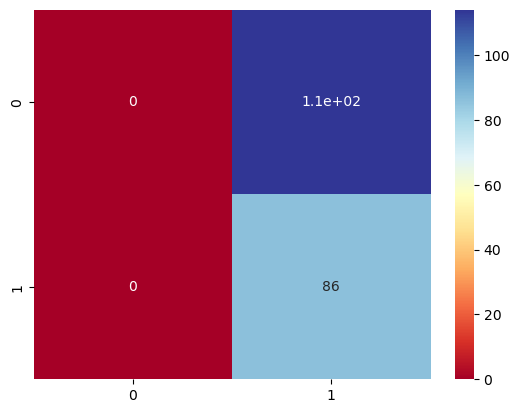

In [47]:
# Initialize and evaluate
model = PassiveAggressiveClassifier(c_value=1.0, iteration_maximum=1000)
evaluate_classifier_scratch(model, X_train, y_train, X_test, y_test, heatmap_color = "RdYlBu")


# DEEPFAKE CLASSIFICATION

In [3]:
# Paths to videos
real_folder = './dataset/Deepfake/real/videos/'
deepfake_folder = './dataset/Deepfake/fake/Deepfakes/videos/'

real_videos = [os.path.join(real_folder, video) for video in os.listdir(real_folder) if video.endswith('.mp4')]
deepfake_videos = [os.path.join(deepfake_folder, video) for video in os.listdir(deepfake_folder) if video.endswith('.mp4')]

# Combine the video paths
video_paths = real_videos + deepfake_videos

# Generate labels (0 for real, 1 for deepfake)
labels = [0]*len(real_videos) + [1]*len(deepfake_videos)


In [4]:
# Initialize MTCNN and InceptionResnetV1
mtcnn_model = MTCNN(keep_all=True)
model = InceptionResnetV1(pretrained='vggface2').eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mtcnn_model = mtcnn_model.to(device)
model = model.to(device)

In [ ]:
def extract_features(video_path, skip_frames=50):  # Default: process every 50th frame
    cap = cv2.VideoCapture(video_path)
    embeddings = []

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % skip_frames != 0:
            continue  # Skip this frame

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        face_tensors = mtcnn_model(frame)
        
        if face_tensors is not None:  
            if len(face_tensors.shape) == 3:
                face_tensors = face_tensors.unsqueeze(0)
            face_tensors = face_tensors.to(device)  
            embedding = model(face_tensors)
            embeddings.append(embedding.detach().cpu().numpy())
    
    cap.release()

    if embeddings:
        return np.mean(np.vstack(embeddings), axis=0)
    else:
        return None


features = []
new_labels = []

for video, label in zip(video_paths, labels):
    feature = extract_features(video)
    if feature is not None:
        features.append(feature)
        new_labels.append(label)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, new_labels, test_size=0.2)

In [7]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [8]:
prediction_y = clf.prediction(X_test)
accuracy = accuracy_score(y_test, prediction_y)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 68.25%


# REFERENCES

## [1] Bisaillon, C. (n.d.). Fake and Real News Dataset. Retrieved May 7, 2023, from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

## [2] Ondyari. (n.d.). Ondyari/faceforensics: Github of the faceforensics dataset. GitHub. https://github.com/ondyari/FaceForensics 
